# Neural Network Text Classifier
We explore a few variants of NN classifiers using word embeddings:
<ul>
<li>Perceptron with One-hot vectors</li>
<li>Perceptron with embeddings</li>
<li>Perceptron with pretrained embeddings</li>
<li>Multilayer perceptron with pretrained embeddings</li>
</ul>
Adapted from code at https://github.com/fchollet/keras/blob/master/examples/imdb_cnn.py

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/Colab Notebooks/HW2'

/content/drive/MyDrive/Colab Notebooks/HW2


## Import modules

In [3]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, Flatten
from keras.layers import Embedding
import numpy as np

### Set parameters

In [4]:
max_num_words = 10000
maxlen = 80    # max sentence length
batch_size = 32
embedding_dims = 50
hidden_dims = 250
VALIDATION_SPLIT = 0.1
epochs = 4

## Loading data

We will use the `Movie Review dataset` from https://www.kaggle.com/pankrzysiu/keras-imdb.
It contains 50,000 highly polarized reviews, preprocessed, tokenized, indexed and stored into numpy arrays.

By convention, index 0 is reserved for padding, hence set `index_from=1`.

In [5]:
from keras.datasets import imdb

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_num_words, index_from=1)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


25000 train sequences
25000 test sequences


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


Pad sequences to `maxlen`.
Padding can be done either at the front or at the end of sentences, depending on the parametere `padding`.

In [6]:
from keras.preprocessing import sequence
x_train = sequence.pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test = sequence.pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 80)
x_test shape: (25000, 80)


### Split train data into train and validation:

In [7]:
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
data = x_train[indices]
labels = y_train[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((22500, 80), (22500,), (2500, 80), (2500,), (25000, 80), (25000,))

Show one example

In [8]:
x_train[0]

array([   1,   87,  325,    6,   26,    4,   18,    2,  434,  221,   68,
        104,  293,    2,    2,    3, 2096,    2,   35,   24, 1019,    9,
        145,  111,  295,    4,  376,   35, 2273,    9, 6255, 4536,   21,
          4,    2,    3,   93,   22,   62,   26,    6,  987,    2, 1634,
          6,   66,  360,   19,   93,   26,    6,  351,    6,    2,   66,
       5487,    2,  255,   45,  105, 1011,    3,  105,  537,   81,    4,
       8269,  221, 4812,   49,    2,   52,    2,  602,   61, 1685,  687,
       2367,  105,    2], dtype=int32)

Recover the words from the word index:

In [9]:
word_index = imdb.get_word_index()
print(f'Found {len(word_index)} unique tokens.')

Found 88584 unique tokens.


In [10]:
index_words = {i:w for w,i in word_index.items()}

Show a review:

In [11]:
' '.join([index_words[i] for i in x_train[2]])

"the this as stopped very this god who me piece guy that fortunately notice people of but and bit portrayed fathers determined dean a nature type smart a system man's br bloody is well this that's that which one of fun monster stop this as you leigh movie and bored to blackmail for ensemble who also you 1995 found first it sky pictures just inspire this heart be satisfaction wider can't this as whatsoever is loaded that a may i"

## Perceptron with one-hot representations

*Build a NN binary classifier in Keras using the following layers:*
1. one-hot input representation
4. Dense

*and a cross-entropy loss function.
You may use pretrained GLoVE embeddings from:*
http://medialab.di.unipi.it/jupyterhub/notebooks/HLT/data/glove.6B/glove.first-100k.6B.50d.txt

In [12]:
model_one_hot = Sequential()

This is NOT a real embedding layer, it is just a trick 
to convert words into one-hot representations.

Note that the embeddinfs are not trained, thet never changes during training.

In [13]:
model_one_hot.add(Embedding(max_num_words,
                    embedding_dims,
                    embeddings_initializer='identity',
                    input_length=maxlen,
                    trainable=False))  # do not train the embeddings

Concatenate the embeddings for all words:

In [14]:
# Add the one-hot vectors for all words into a single BOW vexctor:
import tensorflow as tf
model_one_hot.add(tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x, axis=1)))
#model_one_hot.add(Flatten())

We project onto a single unit output layer, and squash it with a sigmoid:

In [15]:
model_one_hot.add(Dense(1))
model_one_hot.add(Activation('sigmoid'))

## Compile the model
`Keras` is built on top `TensorFlow`. Tensorflow allows you to define a computation graph in `Python`, which is then compiled and run efficiently on the CPU or GPU without the overhead of the Python interpreter.

The `compile` method takes three arguments:
- A loss function. The objective that the model will try to minimize. It can be the name of an existing loss function (such as `categorical_crossentropy` or ` mse`), or it can be an objective function.
- An optimizer. The name of an existing optimizer (such as `rmsprop` or `adagrad`), or an instance of the Optimizer class.
- A list of metrics. For any classification problem you will want to set this to `metrics=['accuracy']`. A metric could be the name of an existing metric or a custom metric function.

In [16]:
model_one_hot.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Show model

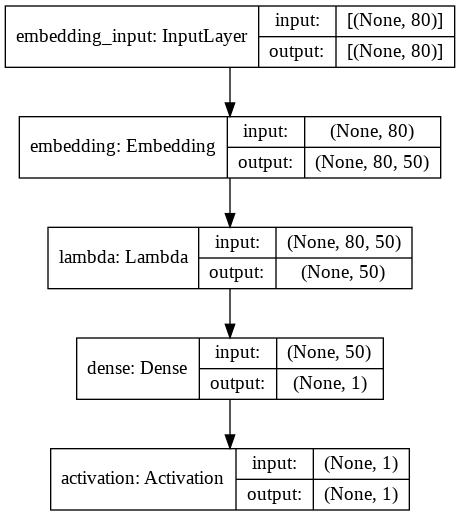

In [17]:
from keras.utils import plot_model

plot_model(model_one_hot, show_shapes=True)

### Train the model

In [18]:
model_one_hot.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))

Epoch 1/4
704/704 [==============================] - 2s 2ms/step - loss: 0.8091 - accuracy: 0.5209 - val_loss: 0.6914 - val_accuracy: 0.5624
Epoch 2/4
704/704 [==============================] - 1s 2ms/step - loss: 0.6733 - accuracy: 0.5857 - val_loss: 0.6679 - val_accuracy: 0.5880
Epoch 3/4
704/704 [==============================] - 1s 2ms/step - loss: 0.6596 - accuracy: 0.6066 - val_loss: 0.6622 - val_accuracy: 0.6036
Epoch 4/4
704/704 [==============================] - 1s 2ms/step - loss: 0.6573 - accuracy: 0.6071 - val_loss: 0.6609 - val_accuracy: 0.6048


### Evaluate
We already used test data during training to check accuracy on held out data, so this step isn't really necessary.

However, let's see how to do it after the training.

In [19]:
loss, accuracy = model_one_hot.evaluate(x_test, y_test, verbose=False)
print(f"Testing Accuracy:  {accuracy:.4f}")

Testing Accuracy:  0.6058


In [20]:
model_one_hot.get_weights()[0][49]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

## Perceptron with Embeddings

In [21]:
model = Sequential()

We start off with an efficient embedding layer which maps
our vocab indices into `embedding_dims` dimensions,
initialized to random values.

In [22]:
model.add(Embedding(max_num_words,
                    embedding_dims,
                    embeddings_initializer='random_uniform',
                    input_length=maxlen))

Concatenate the vectors of all input words:

In [23]:
model.add(Flatten())

Add a hidden layer with a single unit output, and squash it with a sigmoid:

In [24]:
model.add(Dense(1))
model.add(Activation('sigmoid'))

Compile the model:

In [25]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Show the model

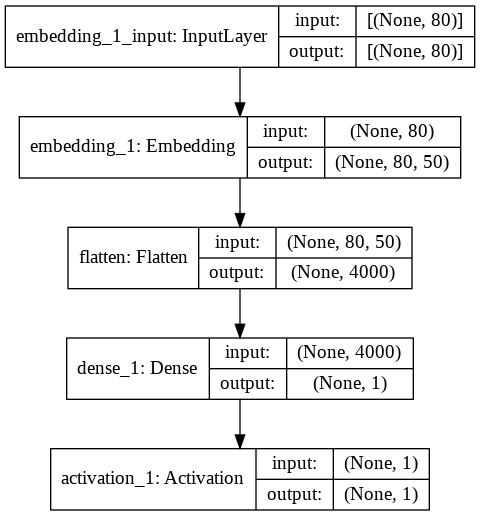

In [26]:
plot_model(model, show_shapes=True)

### Training

In [27]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=(x_test, y_test))

Epoch 1/4
704/704 [==============================] - 6s 8ms/step - loss: 0.6279 - accuracy: 0.6364 - val_loss: 0.4273 - val_accuracy: 0.8021
Epoch 2/4
704/704 [==============================] - 6s 8ms/step - loss: 0.3102 - accuracy: 0.8768 - val_loss: 0.4309 - val_accuracy: 0.8008
Epoch 3/4
704/704 [==============================] - 6s 8ms/step - loss: 0.1558 - accuracy: 0.9616 - val_loss: 0.4644 - val_accuracy: 0.7951
Epoch 4/4
704/704 [==============================] - 5s 7ms/step - loss: 0.0563 - accuracy: 0.9959 - val_loss: 0.5115 - val_accuracy: 0.7913


### Testing

In [28]:
predictions = model.predict(x_test)

In [29]:
predictions

array([[0.0757373 ],
       [0.88563985],
       [0.9672899 ],
       ...,
       [0.02449813],
       [0.2642765 ],
       [0.8668839 ]], dtype=float32)

In [30]:
predictions.round()

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

See the correct results

In [31]:
y_test

array([0, 1, 1, ..., 0, 0, 0])

Compare predictions with the correct results

In [32]:
errors = y_test - predictions.round().flatten()
errors

array([ 0.,  0.,  0., ...,  0.,  0., -1.])

In [33]:
len(errors[errors==0])

19783

In [34]:
len(errors[errors==0])/len(errors)

0.79132

### Evaluation

In [35]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7913


Plot the accuracy through the epochs

In [36]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

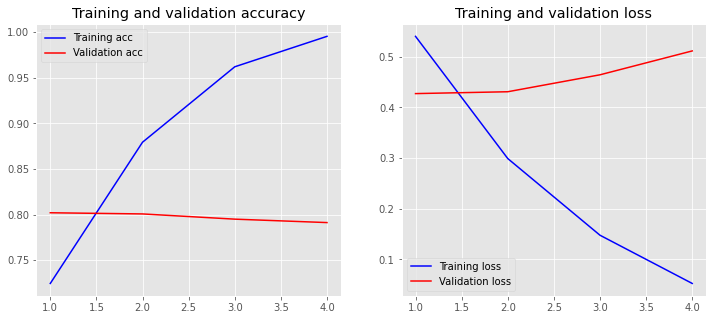

In [37]:
plot_history(history)

## Exploring the fine-tuned embeddings
The model has 4 layers:

In [38]:
model.layers

The first layer is the embeddings layer:

In [39]:
embeddings = model.get_weights()[0]
embeddings.shape

(10000, 50)

Let's see the embeddings for one word:

In [40]:
embeddings[1]

array([ 4.28928622e-25, -8.01277719e-03,  2.99100805e-13, -6.26899041e-19,
       -5.56804308e-31,  8.55278317e-03,  1.03120086e-27, -9.06255678e-04,
        3.29655340e-05, -6.98084850e-03,  1.13495882e-03, -8.40781180e-22,
        3.27428011e-03, -2.04600670e-09, -1.03457573e-07, -9.34397557e-28,
       -3.34441884e-11,  1.04963328e-04, -1.62245669e-06, -9.05423425e-03,
        2.56888871e-03, -1.48890763e-06,  3.54683287e-08,  1.20671540e-17,
        1.05409151e-19, -1.04859843e-10,  4.91006824e-04, -9.07022972e-03,
       -3.32269445e-03,  2.56056734e-03, -1.35233637e-03, -8.07927260e-19,
        1.12231502e-12,  7.22674513e-03,  2.04724242e-26,  5.07551106e-03,
        8.00589449e-04, -5.34680379e-21, -1.15199491e-22,  6.68184877e-23,
       -3.22937965e-03, -7.38806091e-03,  1.39664635e-08, -7.86635908e-04,
        4.87142592e-04,  6.10021416e-05,  1.79468425e-05, -3.89327109e-03,
       -1.93196320e-20,  1.21897631e-11], dtype=float32)

Similarty between two words (for cosine we should divide by their length):

In [41]:
def cosine(x, y):
    return x.dot(y)/(np.linalg.norm(x) * np.linalg.norm(y))

In [42]:
print(index_words[1], index_words[2])
cosine(embeddings[1], embeddings[2])

the and


0.059297327

In [43]:
cosine(embeddings[word_index['film']], embeddings[word_index['films']])

0.17524129

### Evaluation

In [44]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print(f"Testing Accuracy:  {accuracy:.4f}")

Testing Accuracy:  0.7913


### Explore
Experiment yourself, by increasing the number of epochs, adding layers, etc

For example, add an hidden layer and a dropout:

model.add(Dense(hidden_dims))

model.add(Dropout(0.2))

model.add(Activation('relu'))

## Perceptron with pretrained embeddings

Load GloVe embeddings

In [45]:
from glove import Glove
import os

glove_path = 'data/glove.6B.100d.txt'

if not os.path.isfile(glove_path):
    raise RuntimeError("You need to download GloVE Embeddings "+
                       "from http://nlp.stanford.edu/data/")
else:
    print("GloVE available locally")

glove_embeddings = Glove(glove_path)


GloVE available locally


Create a matrix with embeddings for words in the index

In [46]:
num_words = min(max_num_words, len(word_index) + 1) # +1 for padding

Initialize with random weights, to handle OOV words

In [47]:
embedding_dims = glove_embeddings.size
import numpy as np
word_embeddings = np.random.uniform(-0.2, 0.2, (num_words, embedding_dims))

Store embeddings for known words:

In [48]:
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding = glove_embeddings.wv.get(word)
    if embedding is not None:
        # words not found in embeddings will have random weights
        word_embeddings[i] = embedding

### Perceptron Model

In [49]:
model = Sequential()

We now use an embedding layer using the embeddings from GloVe.

We set `trainable=True` in order to get these embbedding to be tuned during the training.<br/>
If we use `trainable=False`, the embedggings will remain unchanged.<br/>
You may want to see what difference this could make to the accuracy of the model.

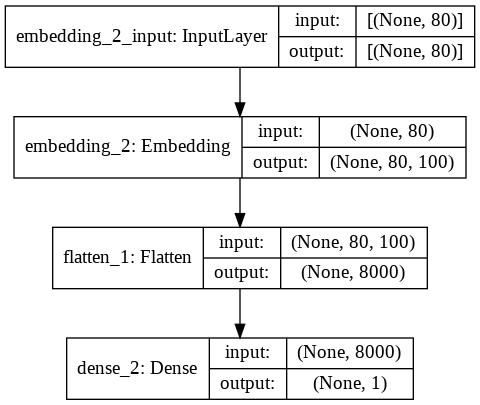

In [50]:
model.add(Embedding(word_embeddings.shape[0],
                    word_embeddings.shape[1], 
                    weights=[word_embeddings], 
                    input_length=maxlen, 
                    trainable=True))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid')) # second layer
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

plot_model(model, show_shapes=True)

### Train the model

In [51]:
history = model.fit(x_train, y_train,
                    epochs=5,
                    validation_data=(x_test, y_test),
                    batch_size=10)

Epoch 1/5
2250/2250 [==============================] - 26s 12ms/step - loss: 0.7479 - accuracy: 0.5661 - val_loss: 0.5548 - val_accuracy: 0.7298
Epoch 2/5
2250/2250 [==============================] - 26s 12ms/step - loss: 0.3447 - accuracy: 0.8492 - val_loss: 0.5595 - val_accuracy: 0.7495
Epoch 3/5
2250/2250 [==============================] - 26s 11ms/step - loss: 0.1370 - accuracy: 0.9591 - val_loss: 0.6432 - val_accuracy: 0.7498
Epoch 4/5
2250/2250 [==============================] - 27s 12ms/step - loss: 0.0428 - accuracy: 0.9928 - val_loss: 0.7382 - val_accuracy: 0.7503
Epoch 5/5
2250/2250 [==============================] - 26s 12ms/step - loss: 0.0110 - accuracy: 0.9998 - val_loss: 0.8320 - val_accuracy: 0.7503


### Evaluate

Training Accuracy: 1.0000
Testing Accuracy:  0.7503


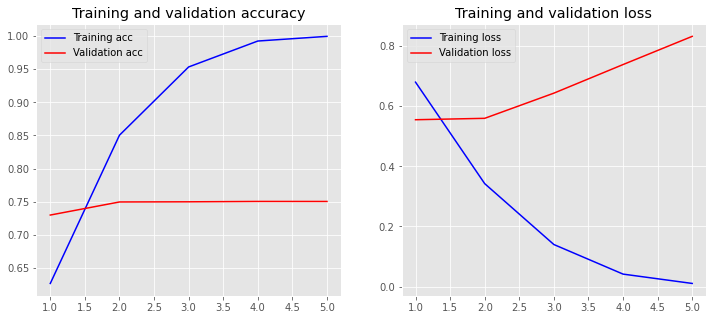

In [52]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print(f"Training Accuracy: {accuracy:.4f}")
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print(f"Testing Accuracy:  {accuracy:.4f}")
plot_history(history)

## Convolutional Neural Network

We use GloVe embeddings in the first layer.

In [53]:
model = Sequential()
model.add(Embedding(word_embeddings.shape[0],
                    word_embeddings.shape[1], 
                    weights=[word_embeddings], 
                    input_length=maxlen, 
                    trainable=True))

We add two convolution layers with MaxPooling.

The next figure illustrates how such a convolution works. It starts by taking a pool of input vectors of the given `pool_size`. These vectors are reduced to a single vector, in the case of `MaxPooling1D` by taking the largest value along each dimension.




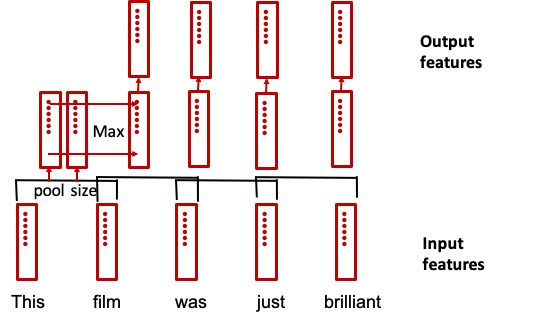

In [54]:
from keras.layers import GlobalMaxPooling1D, Conv1D
model.add(Conv1D(embedding_dims, 7, padding="valid", activation="relu", strides=3))
model.add(Conv1D(embedding_dims, 7, padding="valid", activation="relu", strides=3))
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(embedding_dims, activation="relu"))
model.add(Dropout(0.5))
# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1, activation="sigmoid", name="predictions"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

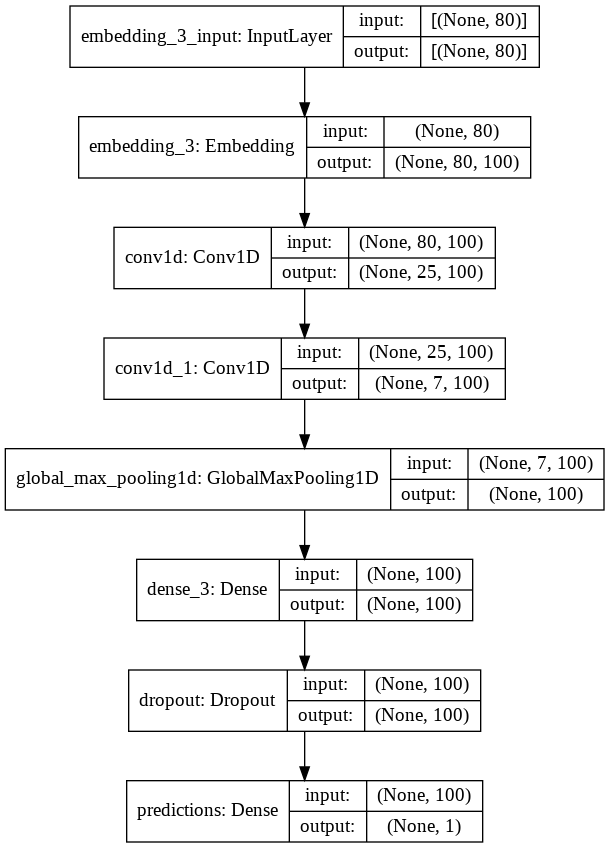

In [55]:
plot_model(model, show_shapes=True)

### Train the model

This will take longer, ...

In [56]:
history = model.fit(x_train, y_train,
                    epochs=5,
                    validation_data=(x_test, y_test),
                    batch_size=10)

Epoch 1/5
2250/2250 [==============================] - 42s 18ms/step - loss: 0.6963 - accuracy: 0.5123 - val_loss: 0.6911 - val_accuracy: 0.5174
Epoch 2/5
2250/2250 [==============================] - 41s 18ms/step - loss: 0.6163 - accuracy: 0.6495 - val_loss: 0.4526 - val_accuracy: 0.7817
Epoch 3/5
2250/2250 [==============================] - 41s 18ms/step - loss: 0.3634 - accuracy: 0.8492 - val_loss: 0.5189 - val_accuracy: 0.7749
Epoch 4/5
2250/2250 [==============================] - 42s 19ms/step - loss: 0.2495 - accuracy: 0.9048 - val_loss: 0.5445 - val_accuracy: 0.7760
Epoch 5/5
2250/2250 [==============================] - 42s 19ms/step - loss: 0.1444 - accuracy: 0.9479 - val_loss: 0.7329 - val_accuracy: 0.7592


### Evaluate

Training Accuracy: 0.9759
Testing Accuracy:  0.7592


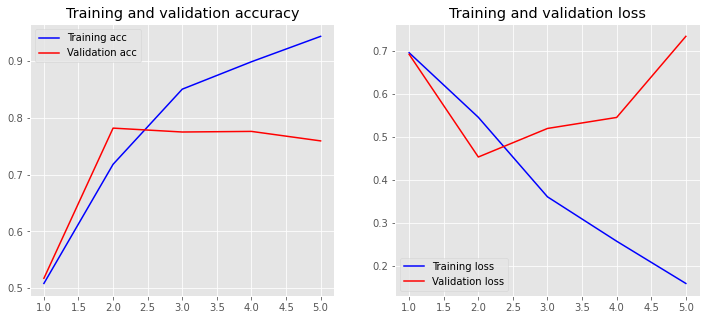

In [57]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)